<a href="https://colab.research.google.com/github/RichardLiuCoding/Publications/blob/main/MOBO_simulation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Authors:**

- Richard (Yu) Liu: https://github.com/RichardLiuCoding

- Utkarsh Pratiush: https://github.com/utkarshp1161

Please cite the following paper (you can also find example results of real-world application of MOBO in this paper) if you use codes based on this workflow:

Liu, Yu, et al. "Automated Materials Discovery Platform Realized: Scanning Probe Microscopy of Combinatorial Libraries." arXiv preprint *arXiv*:2412.18067 (2024).

Please open an issue on my repo here: [link](https://github.com/RichardLiuCoding/Publications), or directly send an email to me: yu93liu@gmail.com


This is an example notebook for building automated experiment workflows powered by multi-objective Bayesian optimization (MOBO).

Here is the structure of the workflow:

**exp:** the main object to handle all the data flow and custom functions
  - **rewards_mobo():** this is the function to extract multiple rewards (can be properties like conductance, film quality, ferroelectric properties directly, or physical descriptors like size of features, peak widths, or even controlling parameters!).
  - **measure()**: this is the function to send the instructions to and read data from your instruments.
  - **generate_seed_mobo()**: generate random seeding for initializeing the MOBO models
  - **step_mobo()**: fit all the measured rewards with their coordinates and compute the acquisition function
  - **run_mobo()**: active learning function to iteratively take new measurements and fit new MOBO models to make decision on next cycle
  - **plot()**: utility functions to plot the real-time results

  


***************

*Key points:*
1. You only need to modify the **rewards_mobo()** and **measure()** functions to fit your own experiment, and then all the other parts should work automatically!
2. Here we provide following options for the acquisitions:
- **qNEHVI** and **qEHVI**: expected hypervolume based acquisitions, whcih are excellent for discovering the real Pareto front quickly
- **EI or UCB**: you can also specify different acquisition functions with different parameters for each reward, and then compute a joint acquisition function based on all of them to decide the next point to measure. This way you will have great freedom to control the exploration vs. exploitation behaviors of each reward.
- This notebook is based on a simulation of the distribution of superconducting gap as a function of defect density. The rewards of gap size, in-gap state, and gap symmetry are extracted from local conductance map.


# Imports

In [7]:
# @title
!pip install botorch==0.10.0
!pip install gpytorch==1.11
# !pip install aespm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 851.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d

# import aespm as ae

In [9]:
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, LogExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

import warnings
warnings.filterwarnings('ignore')


In [10]:
# AC-MOBO related packages

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement

from botorch.optim import optimize_acqf_discrete
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex

import time
import warnings

# from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated

tkwargs = {
    "dtype": torch.float64,
    # "device": "cpu",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(dtype)

In [11]:
# Download the simulation data
!gdown 17010ltCks2OxEqQmNxlJMckF5BxBaKtV

Downloading...
From: https://drive.google.com/uc?id=17010ltCks2OxEqQmNxlJMckF5BxBaKtV
To: /content/mobo_dkl_data2.npz
100% 2.10M/2.10M [00:00<00:00, 192MB/s]


## Custom functions

In [12]:
import types

class Experiment(object):
    '''
    Experiment data structure for SPM auto-optimization simulation.
    '''
    def __init__(self):
        super(Experiment, self).__init__()

        # Initialize parameter dict
        self.param = {}

        # Initialize action list of custom functions
        self.action_list = {}

    def update_param(self, key, value):
        '''
        Update the value stored in obj.param

        Input:
            key     - List: keys to be modifies in obj.param
            value   - List: values to be entered in obj.param['key']

        Output:
            N/A

        Usage:
            obj.update_param(key=['DriveAmplitude', 'Setpoint'], value=[0.1, 0.2])
        '''
        if type(key) is not list:
            key = [key]

        if len(key) == 1:
            self.param[key[0]] = value

        else:
            for i, ix in enumerate(key):
                self.param[ix] = value[i]

    def add_func(self, NewFunc, log=True):
        '''
        Add a custom function as the method to Experiment object.

        Input:
            NewFunc - Function: Custom function defined by user. This function has aceess
                        to all the attributes and methods of obj
        Output:
            N/A
        Usage:
            def measure(self, operation, key, value):
                self.update_param(key=key, value=value)
                self.execute(operation)
            obj.add_func(measure)
        '''
        # method_name = NewFunc.__name__
        # setattr(self, method_name, NewFunc)
        # getattr(self, method_name).__doc__ = NewFunc.__doc__

        # # add new function name to the custom action list
        # self.action_list.append(method_name)

        method_name = NewFunc.__name__

        # add new function name to the custom action list
        self.action_list[method_name] = method_name

        # Bind the function as a method of the instance
        bound_method = types.MethodType(NewFunc, self)

        # # Optionally, update the docstring (if necessary)
        # getattr(self, method_name).__doc__ = NewFunc.__doc__

        # Set the method to the instance
        setattr(self, method_name, bound_method)

    def execute(self, action, value=None, wait=None, log=True, **kwargs):
        '''
        A wrapper of spm_control() function.

        Input:
            action      - String: SPM instructions in hyper-language.
            value       - Int/Float/String: New value for the parameter to change.
            wait        - Float: sleep time after the action is finished.
            log         - Boolean: If true, this action will be logged in obj.log
            kwargs      - Keyword arguments for custom functions

        Return:
            N/A

        Examples:
            # Start a downward scan
            obj.execute(action='ScanDown')
            # Change scan rate to 1 Hz
            obj.execute(action='ScanRate', value=1)
        '''

        wait = 0.35 if wait is None else wait
        if wait <= 0.35:
            wait = 0.35

        # custom functions
        if action in self.action_list:
            if value == None:
                return getattr(self, action)()
            else:
                if type(value) != list and type(value) != np.ndarray:
                    value = [value]
                return getattr(self, action)(*value, **kwargs)
            time.sleep(wait)

        # default action list
        else:
            if type(value) != list and type(value) != np.ndarray:
                value = [value]

In [13]:
def exp_init():
    exp = Experiment()
    exp.add_func(rewards_mobo)
    exp.add_func(measure)
    exp.add_func(generate_seed_mobo)
    exp.add_func(train_BO)
    exp.add_func(step_mobo)
    exp.add_func(run_mobo)
    exp.add_func(plot_mobo)
    return exp

# Load the data

**Setup:**

- Ground truth: gap size, in-gap state, gap symmetry for high-temperature superconductor
- the same initial starting points for all the simulation  
- Compare the performance of the following acquisitions:
    - **qNEHVI** (a-noisy expected hypervolume improvement)
    - joint **UCB**
    - pure **uncertainty**-driven exploration


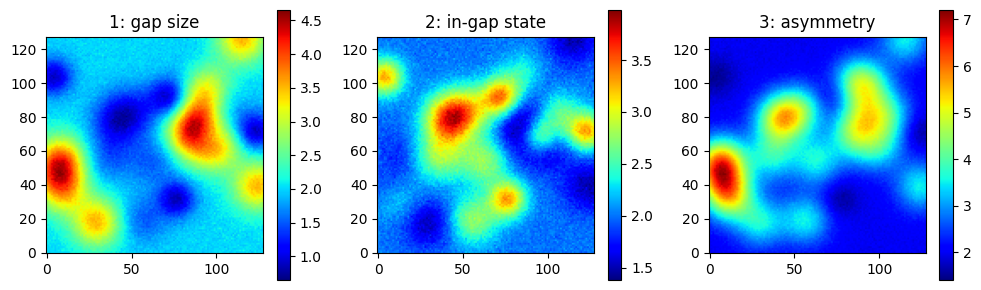

In [14]:
# data = np.load(os.path.join('data', 'mobo_dkl_data2.npz'))
data = np.load('mobo_dkl_data2.npz')

topo = data['topo'][::2, ::2]
rewards = data['rewards']

rewards_new = []

for i in range(len(rewards)):
    rewards_new.append(rewards[i][::2, ::2])

rewards = rewards_new

titles = ['1: gap size', '2: in-gap state', '3: asymmetry']
img = []

# plt.figure(figsize=[4,4])
# plt.imshow(topo)
# plt.tight_layout()

fig, ax = plt.subplots(1,3, figsize=[10, 3])
for i in range(3):
    img.append(ax[i].imshow(rewards[i], origin='lower', cmap=plt.cm.jet))
    plt.colorbar(img[i], ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()

# MOBO related functions

In [15]:
exp = Experiment()

## Rewards

In [16]:
def rewards_mobo(self, x, y):
    gap_size = self.param['rewards'][0][x,y]
    residual = self.param['rewards'][1][x,y]
    asymmetry = self.param['rewards'][2][x,y]

    return np.array([gap_size, residual, asymmetry])

exp.add_func(rewards_mobo)

## Measure function

In [17]:
def measure(self, x, y):
    return self.rewards_mobo(int(x), int(y))

exp.add_func(measure)

## Seeding function

In [18]:
def generate_seed_mobo(self, num=10, repeat=1, seed=None, save=None):

    if seed is None:
        np.random.seed(35)

    X = self.param['X_array']
    N = self.param['num_rewards']
    idx = np.random.randint(0, len(X), num)

    X_measured = X[idx]
    X_exp_measured = self.param['X_exp'][idx]
    y_measured = np.zeros([len(idx), N])

    indices_measured = idx
    indices_unmeasured = np.delete(np.arange(len(X)), idx, 0)

    self.update_param('num_seed', num)
    self.update_param('idx', idx)
    self.update_param('indices_unmeasured_seed', indices_unmeasured)
    self.update_param('indices_measured_seed', indices_measured)

    for i in range(num):
        x, y = X_exp_measured[i]
        y_measured[i] = self.measure(x, y)

    fig, ax = plt.subplots(1,N, figsize=[12,3])
    for i in range(N):
        ax[i].scatter(X_measured[:, 1], X_measured[:, 0], c=y_measured[:,i], s=160, marker='s')

    for axis in ax:
        axis.set_xlabel('x')
        axis.set_ylabel('y')

    plt.tight_layout()

    X_unmeasured = np.delete(X, idx, axis=0)
    y_measured = np.asarray(y_measured, dtype=np.float64)

    X_exp_unmeasured = np.delete(self.param['X_exp'], idx, axis=0)
    self.update_param('X_exp_measured', X_exp_measured)
    self.update_param('X_exp_unmeasured', X_exp_unmeasured)

    self.update_param('X_exp_measured_seed', X_exp_measured)
    self.update_param('X_exp_unmeasured_seed', X_exp_unmeasured)

    self.update_param('X_measured_array_seed', X_measured)
    self.update_param('X_unmeasured_array_seed', X_unmeasured)
    self.update_param('y_measured_array_seed', y_measured)

    self.update_param('X_measured_tensor_seed', torch.from_numpy(X_measured))
    self.update_param('X_unmeasured_tensor_seed', torch.from_numpy(X_unmeasured))
    self.update_param('y_measured_tensor_seed', torch.from_numpy(y_measured))
    if save is not None:
        np.savez('{}.npz'.format(save), X_measured=X_measured, y_measured=y_measured)
    self.execute('Stop')

exp.add_func(generate_seed_mobo)

## MOBO fitting

In [19]:
def step_mobo(self, acquisition='qNEHVI', beta=4, delta=5, MC_SAMPLES = 64,
              N_BATCH = 20, BATCH_SIZE=1, NUM_RESTARTS = 10, EPSILON=0.05, RAW_SAMPLES = 128):

    train_x = self.param['X_measured_tensor'].to(self.param['device'])
    train_obj = self.param['y_measured_tensor'].to(self.param['device'])

    if len(train_x[0]) == 2:
        bounds = torch.stack([torch.ones(2), 1 * torch.ones(2)]).to(self.param['device'])
        standard_bounds = torch.zeros(2, 2, dtype=torch.float64).to(self.param['device'])
        standard_bounds[1] = 1
    elif len(train_x[0]) == 3:
        bounds = torch.stack([torch.ones(3), 1 * torch.ones(3)]).to(self.param['device'])
        standard_bounds = torch.zeros(2, 3, dtype=torch.float64).to(self.param['device'])
        standard_bounds[1] = 1
    elif len(train_x[0]) == 1:
        bounds = torch.stack([torch.ones(1), 1 * torch.ones(1)]).to(self.param['device'])
        standard_bounds = torch.zeros(2, 1, dtype=torch.float64).to(self.param['device'])
        standard_bounds[1] = 1
    else:
        print("Only 2 and 3 variables are supported!")

    X = self.param['X_tensor'].to(self.param['device'])

    # Initialize the model
    models = []
    N = train_obj.shape[-1]
    for i in range(train_obj.shape[-1]):
        train_y = train_obj[..., i : i + 1]
        models.append(
            SingleTaskGP(
                train_x, train_y, #outcome_transform=Standardize(m=1)
            )
        )

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_mll(mll)

    # if sampler is None:
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    ref_point = torch.zeros(N, device=self.param['device'])

    if acquisition=='qNEHVI':
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point,  # Use the filtered reference point
            X_baseline=bounds,  # Only use non-ε-dominated points
            prune_baseline=True,  # Remove points with zero probability of Pareto optimality
            sampler=sampler,
        )
    elif acquisition == 'qEHVI':
        with torch.no_grad():
            pred = model.posterior(train_x).mean

        # if sampler is None:
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        partitioning = FastNondominatedPartitioning(
            ref_point=torch.max(train_obj, dim=0).values - delta,
            Y=pred,
            )

        acq_func = qExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point,
            partitioning=partitioning,
            sampler=sampler,
        )
    elif acquisition == 'EI':
        pass
    elif acquisition == 'UCB':
        pass

    x_list = [X] * N

    # Evaluate the ModelListGP
    model.eval()
    outputs = model(*x_list)
    pred = [posterior.mean.cpu().detach().numpy() for posterior in outputs]
    # res_std =  [posterior.std.cpu().detach().numpy() for posterior in outputs]

    self.update_param('pred', pred)

    return acq_func

exp.add_func(step_mobo)

def train_BO(self, i, acquisition='EI', beta=10):

    device = self.param['device']
    dtype = self.param['dtype']

    train_x = self.param['X_measured_tensor'].to(self.param['device'])
    y_train = torch.tensor(self.param['y_measured_tensor'][:, i]).to(self.param['device'])

    # Normalize y_train
    y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

    gp_model = SingleTaskGP(train_x, y_train.unsqueeze(-1))

    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    fit_gpytorch_mll(mll)

    return gp_model

exp.add_func(train_BO)

## Active learning

In [20]:
def run_mobo(self, fresh=True, num_steps=30, repeat=1,
           show=True, acquisition='qNEHVI', beta=10, penalty_weight=0.5, save=None, **kwargs):
    if fresh:
        self.update_param('X_measured_array', self.param['X_measured_array_seed'])
        self.update_param('X_unmeasured_array', self.param['X_unmeasured_array_seed'])
        self.update_param('y_measured_array', self.param['y_measured_array_seed'])

        self.update_param('X_exp_measured', self.param['X_exp_measured_seed'])
        self.update_param('X_exp_unmeasured', self.param['X_exp_unmeasured_seed'])

        self.update_param('X_measured_tensor', self.param['X_measured_tensor_seed'])
        self.update_param('X_unmeasured_tensor', self.param['X_unmeasured_tensor_seed'])
        self.update_param('y_measured_tensor', self.param['y_measured_tensor_seed'])

        self.update_param('indices_measured', self.param['indices_measured_seed'])
        self.update_param('indices_unmeasured', self.param['indices_unmeasured_seed'])

    device = self.param['device']
    dtype = self.param['dtype']

    num_rewards = len(self.param['y_measured_tensor'][0])

    for step in range(num_steps):
        acq_func = []
        acq = 0
        norm_factor = []
        acq_values = []
        acq_values_penalized = []
        X_candidates = self.param['X_unmeasured_tensor']
        y_pred = np.zeros([num_rewards, len(self.param['X_array'])])

        if acquisition=='qNEHVI' or acquisition=='qEHVI':
            acq_func = self.step_mobo(acquisition=acquisition, **kwargs)
            # candidate_indices = self.param['indices_unmeasured']
            new_x, acq_value = optimize_acqf_discrete(
                acq_function=acq_func,
                choices=X_candidates,
                q=1,
            )
            selected_idx = torch.where(
                (self.param['X_tensor'] == new_x.view(1, -1)).all(dim=1)
            )[0].item()

        else:
            penalties = torch.zeros_like(self.param['y_measured_tensor'][:, 0]).to(device)
            X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)
            acquired_features = self.param['X_measured_tensor']
            acquired_features_flat = acquired_features.reshape(acquired_features.size(0), -1)

            # if len(acquired_indices) > 0:  # Only apply penalty if there are acquired points
            # Calculate pairwise distances between candidates and acquired points
            # Using a more numerically stable distance calculation
            candidates_norm = (X_candidates_flat ** 2).sum(dim=1, keepdim=True)  # [n_candidates, 1]
            acquired_norm = (acquired_features_flat ** 2).sum(dim=1, keepdim=True).t()  # [1, n_acquired]
            # Calculate the dot product
            dot_product = torch.mm(X_candidates_flat, acquired_features_flat.t())  # [n_candidates, n_acquired]
            # Calculate squared distances
            squared_distances = candidates_norm + acquired_norm - 2 * dot_product  # [n_candidates, n_acquired]
            # Find minimum distance for each candidate point
            min_distances, _ = torch.min(squared_distances, dim=1)  # [n_candidates]
            # Convert to penalties: high penalty for small distances
            threshold = 1e-6
            min_distances = torch.clamp(min_distances, min=threshold)
            # Scale the penalties - adaptive scaling based on data distribution
            proximity_scale = torch.mean(min_distances) * 0.5  # Adjust this value to control penalty strength
            penalties = torch.exp(-min_distances / proximity_scale)

            for i in range(num_rewards):
                model = self.train_BO(i, acquisition=acquisition, beta=beta)

                model.eval()
                # model_list.append(model)
                y_train = torch.tensor(self.param['y_measured_tensor'][:, i]).to(self.param['device'])
                y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
                norm_factor.append([y_train.max() - y_train.min(), y_train.min()])
                if acquisition=='EI':
                    acq_func.append(LogExpectedImprovement(model=model, best_f=y_train.max().to(self.param['device'])))
                    acq_temp =  acq_func[i](X_candidates.unsqueeze(-2))
                elif acquisition=='UCB':
                    acq_func.append(UpperConfidenceBound(model=model, beta=beta).to(self.param['device']))
                    acq_temp =  acq_func[i](X_candidates.unsqueeze(-2))
                else: # Pure uncertainty driven
                    posterior = model.posterior(X_candidates.unsqueeze(-2))
                    acq_temp = posterior.variance.sqrt()
                acq_values.append((acq_temp - acq_temp.min()) / (acq_temp.max() - acq_temp.min()))
                acq_values_penalized.append(acq_values[i] - penalty_weight * penalties)
                acq += acq_values[i].cpu().detach().numpy()
                posterior = model.posterior(self.param['X_tensor'])
                y_pred[i] = posterior.mean.cpu().detach().numpy()[:,0]

            self.update_param('pred', y_pred)

            if acquisition=='EI' or acquisition=='UCB':
                candidate_indices = self.param['indices_unmeasured']
                # Apply penalties to acquisition values
                # Stack acquisition values into a single tensor of shape (Q, 2)
                acq_matrix = torch.stack(acq_values_penalized, dim=1)
                # Determine Pareto optimal points
                pareto_mask = is_non_dominated(acq_matrix)
                # Convert mask to boolean numpy array
                pareto_mask_np = pareto_mask.cpu().numpy()
                # Extract Pareto optimal indices
                pareto_indices = np.where(pareto_mask_np)[0]
                if len(pareto_indices) == 0:
                    # If no Pareto optimal points, fallback to selecting the point with the highest acq_1
                    selected_candidate_idx = torch.argmax(acq_values_penalized[0]).item()
                else:
                    # Extract acquisition values for Pareto optimal points
                    aggregate_acq = 0
                    for j in range(num_rewards):
                        aggregate_acq +=  acq_values_penalized[j][pareto_mask]  # Simple sum; can also use weighted sum or average
                    # Select the Pareto point with the highest aggregate acquisition value
                    selected_pareto_idx = torch.argmax(aggregate_acq).item()
                    selected_candidate_idx = pareto_indices[selected_pareto_idx]
            else: # This is where you have the freedom to assign different acquisitions for different rewards
                candidate_indices = self.param['indices_unmeasured']
                selected_candidate_idx = np.argmax(acq).item()
                # selected_candidate_idx = pareto_indices[selected_pareto_idx]

            # Map the selected candidate index to the original dataset index
            selected_idx = candidate_indices[selected_candidate_idx]

        # self.param['acq'] = acq_func(X_candidates)
        x, y = self.param['X_exp'][selected_idx]

        next_measure = self.measure(x, y)

        self.update_param('indices_unmeasured_prev', self.param['indices_unmeasured'])

        self.update_param('indices_measured', torch.cat((torch.tensor(self.param['indices_measured']), torch.tensor([selected_idx])), dim=0))
        self.update_param('X_measured_tensor', self.param['X_tensor'][self.param['indices_measured']])
        self.update_param('y_measured_tensor', torch.cat((self.param['y_measured_tensor'], torch.tensor(next_measure).unsqueeze(0)), dim=0))
        # self.update_param('indices_measured', torch.cat((torch.tensor(self.param['indices_measured']), torch.tensor(selected_index)), dim=0))

        self.update_param('indices_unmeasured', np.delete(np.arange(len(self.param['X_tensor'])), self.param['indices_measured'], 0))
        self.update_param('X_unmeasured_tensor', self.param['X_tensor'][self.param['indices_unmeasured']])
        self.update_param('X_exp_measured', self.param['X_exp'][self.param['indices_measured']])

        self.plot_mobo(step)

exp.add_func(run_mobo)

In [21]:
def plot_mobo(self, step, title=''):

    X = self.param['X_array']

    y_measured = self.param['y_measured_tensor'].detach().numpy()
    X_measured_temp = self.param['X_measured_tensor'].detach().numpy()

    X_measured = np.copy(X_measured_temp)
#     for i in range(len(X_measured_temp)):
#         X_measured[i] = conver_unit(X_measured_temp[i], limits=self.param['limits'])

    y_pred = self.param['pred']

    num_seed = self.param['num_seed']

    x_labels = ['Reward 2', 'Reward 3', 'Reward 3']
    y_labels = ['Reward 1', 'Reward 1', 'Reward 2']

    clear_output(wait=True)
    fig, ax = plt.subplots(2, 3, figsize=(10, 6))
    im1 = ax[0,0].scatter(X[:, 1], X[:, 0], c=y_pred[0], s=40, cmap='jet')
    ax[0,0].set_title("Reward 1 at {}".format(step))

    im2 = ax[0, 1].scatter(X[:, 1], X[:, 0], c=y_pred[1], s=40, cmap='jet')
    ax[0, 1].set_title("Reward 2")

    im3 = ax[0,2].scatter(X[:, 1], X[:, 0], c=y_pred[2], s=40, cmap='jet')
    ax[0,2].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')

    ax[0,2].scatter(X_measured[num_seed:, 1], X_measured[num_seed:, 0], marker='o', s=50,
                        c = np.arange(len(X_measured)-num_seed), cmap = 'rainbow')
    ax[0,2].set_title("Reward 3")

    t = np.arange(len(y_measured))

    ax[1,0].scatter(y_measured[:, 1], y_measured[:, 0], c=t, s=40, cmap='jet')
    ax[1,1].scatter(y_measured[:, 2], y_measured[:, 0], c=t, s=40, cmap='jet')
    ax[1,2].scatter(y_measured[:, 2], y_measured[:, 1], c=t, s=40, cmap='jet')

    for i, axis in enumerate(ax.flatten()):
        if i < 3:
            axis.set_xlabel('x1')
            axis.set_ylabel('x2')
        else:
            axis.set_xlabel(x_labels[i-3])
            axis.set_ylabel(y_labels[i-3])

    plt.colorbar(im1, ax=ax[0,0])
    plt.colorbar(im2, ax=ax[0,1])
    plt.colorbar(im3, ax=ax[0,2])
#     plt.colorbar(im4, ax=ax[1,1])
    plt.tight_layout()
    plt.show()

exp.add_func(plot_mobo)

# Acquisition of qNEHVI

In [22]:
# Generate the safe parameters for the BO and MOBO

# exp.execute('Stop')

# file save name
# save_name = 'output/250315_Red3_MOBO'

num1 = 128
num2 = 128

# x1 is the drive
x1 = np.arange(128)
x2 = np.arange(128)

exp.update_param('limits', np.array([[np.min(x1), np.max(x1)], [np.min(x2), np.max(x2)]]))

x_exp = []
x_norm = []

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

for i in range(len(x1)):
    for j in range(len(x2)):

        x_exp.append([x1[i], x2[j]])
        x_norm.append([x1_norm[i], x2_norm[j]])

x_exp =  np.asarray(x_exp, dtype=np.float64)
x_norm = np.asarray(x_norm, dtype=np.float64)
X_norm = torch.from_numpy(x_norm)

exp.update_param('X_exp', x_exp)
exp.update_param('X_array', x_norm)
exp.update_param('X_tensor', X_norm)

exp.update_param('num1', num1)
exp.update_param('num2', num2)
exp.update_param('num_rewards', 3)
exp.update_param('rewards', np.array(rewards_new))
exp.update_param('dtype', torch.float64,)
exp.update_param('device', 'cpu')



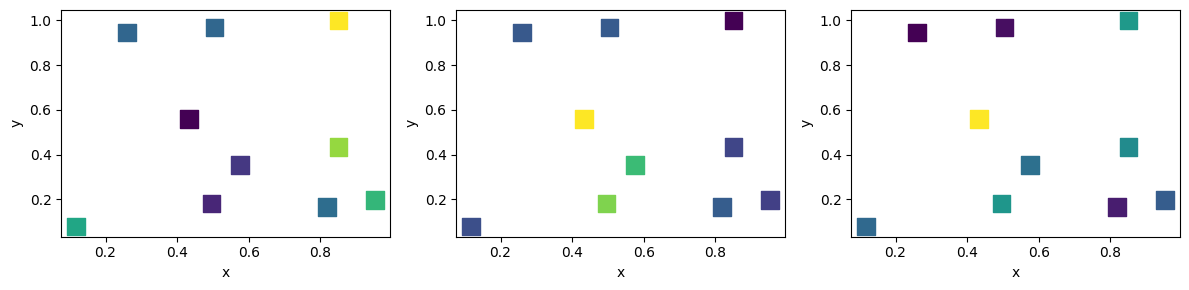

In [23]:
exp.generate_seed_mobo(num=10)

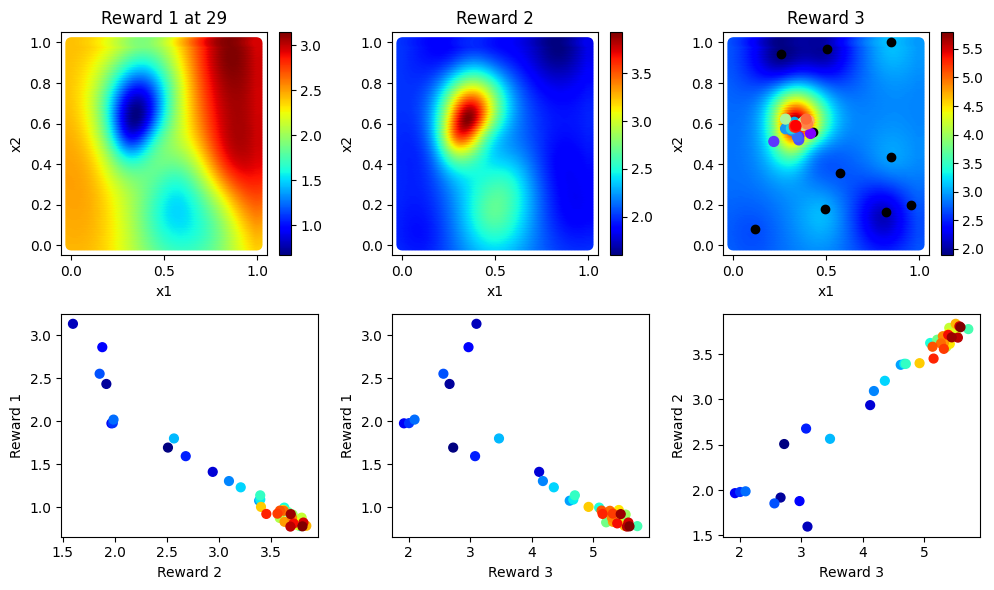

In [24]:
exp.run_mobo(num_steps=30,show=True, fresh=True, )

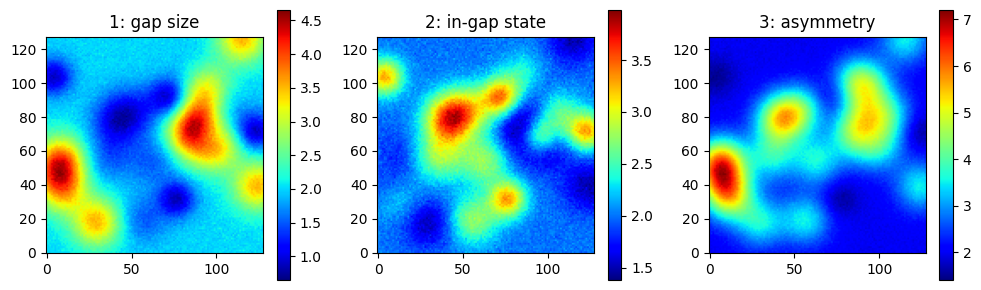

In [25]:
# Here is the ground truth for comparison
fig, ax = plt.subplots(1,3, figsize=[10, 3])
for i in range(3):
    img.append(ax[i].imshow(rewards[i], origin='lower', cmap=plt.cm.jet))
    plt.colorbar(img[i], ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()

## UCB acquisition function

In [26]:
# Generate the safe parameters for the BO and MOBO

exp = exp_init()

num1 = 128
num2 = 128

# x1 is the drive
x1 = np.arange(128)
x2 = np.arange(128)

exp.update_param('limits', np.array([[np.min(x1), np.max(x1)], [np.min(x2), np.max(x2)]]))

x_exp = []
x_norm = []

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

for i in range(len(x1)):
    for j in range(len(x2)):

        x_exp.append([x1[i], x2[j]])
        x_norm.append([x1_norm[i], x2_norm[j]])

x_exp =  np.asarray(x_exp, dtype=np.float64)
x_norm = np.asarray(x_norm, dtype=np.float64)
X_norm = torch.from_numpy(x_norm)

exp.update_param('X_exp', x_exp)
exp.update_param('X_array', x_norm)
exp.update_param('X_tensor', X_norm)

exp.update_param('num1', num1)
exp.update_param('num2', num2)
exp.update_param('num_rewards', 3)
exp.update_param('rewards', np.array(rewards_new))
exp.update_param('dtype', torch.float64,)
exp.update_param('device', 'cpu')



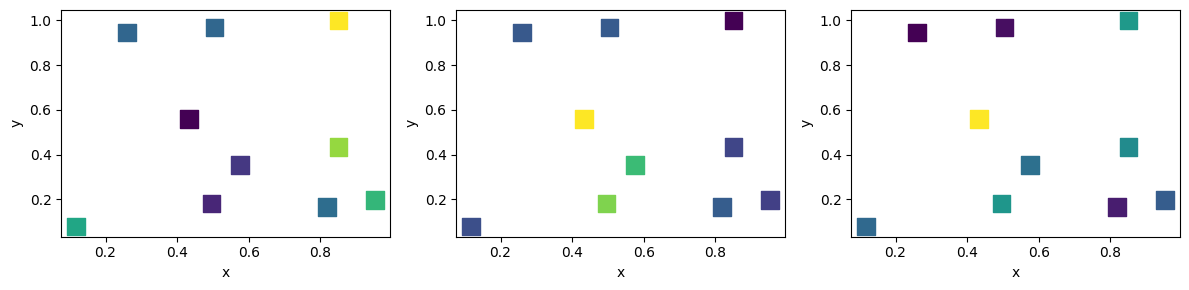

In [27]:
exp.generate_seed_mobo(num=10)

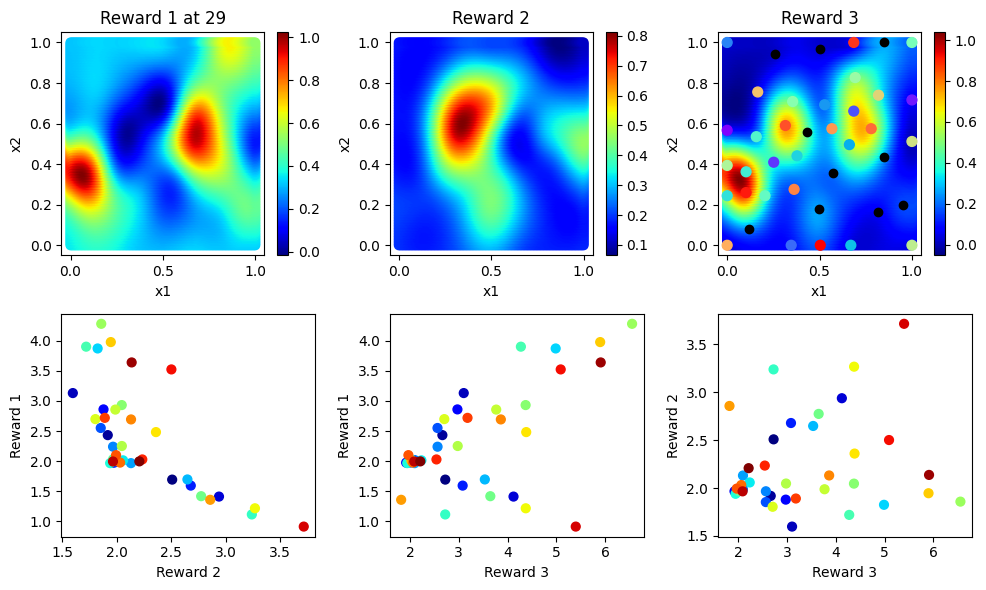

In [28]:
exp.run_mobo(num_steps=30,show=True, acquisition='UCB', beta=10, fresh=True, )

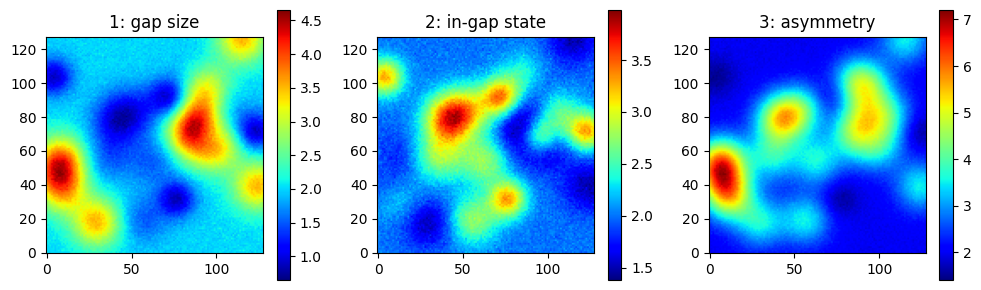

In [29]:
fig, ax = plt.subplots(1,3, figsize=[10, 3])
for i in range(3):
    img.append(ax[i].imshow(rewards[i], origin='lower', cmap=plt.cm.jet))
    plt.colorbar(img[i], ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()

## Pure uncertainty driven exploration

In [30]:
# Generate the safe parameters for the BO and MOBO

exp = exp_init()

num1 = 128
num2 = 128

# x1 is the drive
x1 = np.arange(128)
x2 = np.arange(128)

exp.update_param('limits', np.array([[np.min(x1), np.max(x1)], [np.min(x2), np.max(x2)]]))

x_exp = []
x_norm = []

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

for i in range(len(x1)):
    for j in range(len(x2)):

        x_exp.append([x1[i], x2[j]])
        x_norm.append([x1_norm[i], x2_norm[j]])

x_exp =  np.asarray(x_exp, dtype=np.float64)
x_norm = np.asarray(x_norm, dtype=np.float64)
X_norm = torch.from_numpy(x_norm)

exp.update_param('X_exp', x_exp)
exp.update_param('X_array', x_norm)
exp.update_param('X_tensor', X_norm)

exp.update_param('num1', num1)
exp.update_param('num2', num2)
exp.update_param('num_rewards', 3)
exp.update_param('rewards', np.array(rewards_new))
exp.update_param('dtype', torch.float64,)
exp.update_param('device', 'cpu')



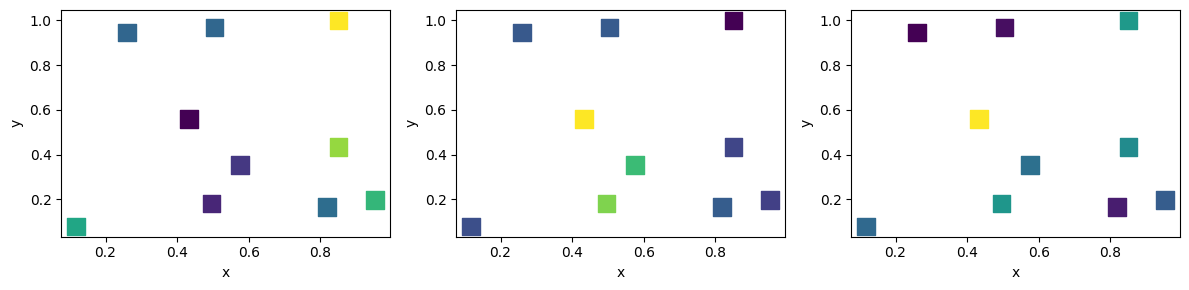

In [31]:
exp.generate_seed_mobo(num=10)

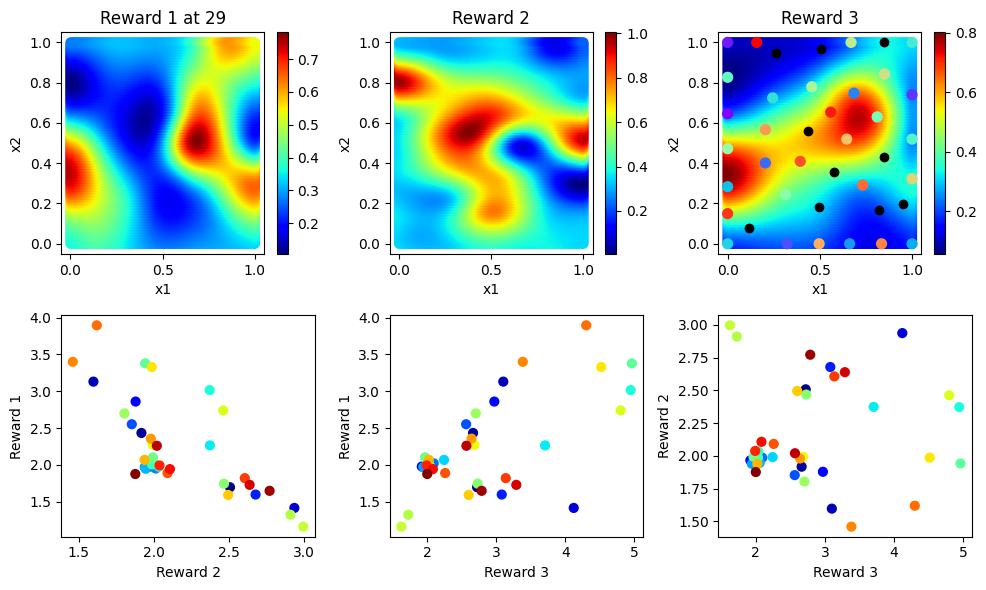

In [32]:
exp.run_mobo(num_steps=30,show=True, acquisition='Uncertainty', fresh=True, )

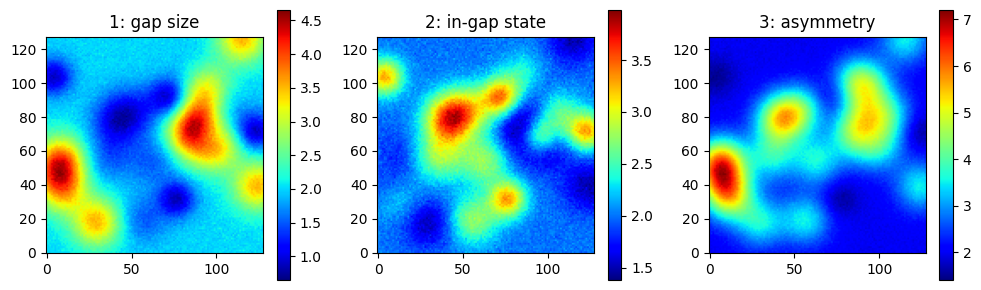

In [33]:
fig, ax = plt.subplots(1,3, figsize=[10, 3])
for i in range(3):
    img.append(ax[i].imshow(rewards[i], origin='lower', cmap=plt.cm.jet))
    plt.colorbar(img[i], ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()

# Conclusion

- Use EHVI-based acquisition if efficient Pareto search is desired
- Use joint UCB if balancing Pareto search and global uncertainty is wanted
- Freely use different acquisition functions for different objectives!